# define inputs

In [30]:
## defines constant to change, you can customize these to your own portfolio
Return = 0.06
years = 5
starting_tfsa = 5000
TFSA_cont = 5500
starting_rrsp = 50000
income = 75000
rrsp_cont = min(26000,income * 0.18)
starting_general = 10000
general_cont = 2000

total = starting_tfsa + starting_rrsp + starting_general

In [31]:
## loads packages that will be ised throughout
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  



In [32]:
##makes function to calaulate the year over year cost
## This function will take existing terms of the accounts and move it forward one year in details
def calculate(MER, AMF, balance, Trading_fee):
    new = balance*(1 + Return - MER) - AMF - Trading_fee
    tot_MER = (balance*(1 + Return) - new)/balance
    Tot_return = new/balance
    return new, tot_MER, Tot_return;

## aggregates for standard constant fee structue.  If they change Custom functions will be used
## This function will call the calculate function for the years sepcified for the account details used specified
def aggregate(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) ) ## defines the vector
    values[0] = calculate(MER, AMF, balance, trading_fee) ## sets the value for starting values
    for year in range(years): ## for each of the years specified
        if year >0:
            ## iterates and finds the new values
            values[year] = calculate(MER, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values



## RBC domionion secutires
## This is a modification of the aggregate function, what makes this unique is the fixed TFSA fee of 1%
def RBC_agg(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    TFSA = np.zeros ((years,3))
    TFSA[0] = starting_tfsa + TFSA_cont
    values[0] = calculate(MER, AMF + 0.01*TFSA[0,0], balance, trading_fee)
    for year in range(years):
        if year >0:
            TFSA[year] = calculate(MER, 0.01*TFSA[year-1,0], TFSA[year-1,0]+ TFSA_cont, trading_fee)
            values[year] = calculate(MER, AMF + 0.01*TFSA[year,0], values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
    return values



##wealth simple  assumes MER of 0.2%
## This is the same as the aggregate function however there are fee discontunities
def wealth_simple_agg(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if balance > 100000:
        values[0] = calculate(0.006, AMF, balance, trading_fee)
    else:
        values[0] = calculate(0.007, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            if values[year-1,0] + TFSA_cont + rrsp_cont + general_cont > 100000:
                values[year] = calculate(0.006, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
            else:
                values[year] = calculate(0.007, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)               
    return values


## Nest wealth  webiste claims MER is 0.13%
## This is the same as the aggregate function however there are fee discontunities
def nest_wealth_agg(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if balance < 75000:
        values[0] = calculate(MER, 415, balance, trading_fee)
    elif balance < 150000 & balance:
        values[0] = calculate(MER, 655, balance, trading_fee)
    else:
        values[0] = calculate(MER, 1135, balance, trading_fee)
    for year in range(years):
        if year >0:
            if values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 75000:
                values[year] = calculate(MER, 415, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 150000:
                values[year] = calculate(MER, 655, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)  
            else:
                values[year] = calculate(MER, 1135, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values

## says funds have an MER of 0.20% to 0.35%
## This is the same as the aggregate function however there are fee discontunities
## This is more unique as the intiail investments are always charged at the same rate.
def bmo_smartfolio_agg(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if  balance < 100000:
        MER = 0.0095
    elif balance < 250000:
        MER = (100000*0.0095 + (balance-100000)*0.0085)/balance
    elif balance < 500000:
        MER = (100000*0.0095 + 150000*0.0085 + (balance - 250000)*0.0075)/balance
    else:
        MER = (100000*0.0095 + 150000*0.0085 + 250000*0.0075 +(balance - 500000)*0.0065)/balance
    values[0] = calculate(MER, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            bal = values[year-1,0] + TFSA_cont + rrsp_cont + general_cont
            if  bal < 100000:
                MER = 0.0095
            elif bal < 250000:
                MER = (100000*0.0095 + (bal - 100000)*0.0085)/bal
            elif bal < 500000:
                MER = (100000*0.0095 + 150000*0.0085 + (bal - 250000)*0.0075)/bal
            else:
                MER = (100000*0.0095 + 150000*0.0085 + 250000*0.0075 +(bal - 500000)*0.0065)/bal
            values[year] = calculate(MER, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values



## wleathbar
## This is the same as the aggregate function however there are fee discontunities
## This is more unique as the intiail investments are always charged at the same rate.
def wealthbar(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if  balance < 150000:
        MER = (max(0,balance - 5000)*0.006)/balance  ## to ensure MER is always positive
    elif balance < 500000:
        MER = (145000*0.006 + (balance-150000)*0.004)/balance
    else:
        MER = (145000*0.006 +350000*0.004 + (balance - 500000)*0.0035)/balance
    MER = MER + 0.0033
    values[0] = calculate(MER, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            bal = values[year-1,0] + TFSA_cont + rrsp_cont + general_cont
            if  bal < 150000:
                MER = (max(0, bal - 5000)*0.006)/bal
            elif values[year-1,0] < 500000:
                MER = (145000*0.006 + (bal - 150000)*0.004)/bal
            else:
                MER = (145000*0.006 +350000*0.004 + (bal - 500000)*0.0035)/bal 
            MER = MER + 0.0033
            values[year] = calculate(MER, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values




## says MER range from 0.21 to 1.21%
## This is the same as the aggregate function however there are fee discontunities
def port_iq(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if balance < 100000:
        values[0] = calculate(0.009, AMF, balance, trading_fee)
    elif balance < 250000:
        values[0] = calculate(0.008, AMF, balance, trading_fee)
    elif balance < 500000:
        values[0] = calculate(0.007, AMF, balance, trading_fee)
    elif balance < 1000000:
        values[0] = calculate(0.006, AMF, balance, trading_fee)
    else:
        values[0] = calculate(0.0055, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            if values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 100000:
                values[year] = calculate(0.009, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 250000:
                values[year] = calculate(0.008, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)  
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 500000:
                values[year] = calculate(0.007, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 1000000:
                values[year] = calculate(0.006, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
            else:
                values[year] = calculate(0.0055, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values

## Modern advisor webiste sights that MER is 0.25% for underlying funds
## This is the same as the aggregate function however there are fee discontunities
def modern_ad(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if balance < 10000:
        values[0] = calculate(0.0025, AMF, balance, trading_fee)
    elif balance < 100000:
        values[0] = calculate(0.0075, AMF, balance, trading_fee)
    elif balance < 500000:
        values[0] = calculate(0.0065, AMF, balance, trading_fee)
    else:
        values[0] = calculate(0.006, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            if values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 10000:
                values[year] = calculate(0.0025, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 100000:
                values[year] = calculate(0.0075, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)  
            elif values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 500000:
                values[year] = calculate(0.0065, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
            else:
                values[year] = calculate(0.006, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values


## Just wealth MER's are assumed to be standard 0.25% listed on their website
## This is the same as the aggregate function however there are fee discontunities
def just_wealth(MER, AMF, balance, trading_fee):
    values = np.zeros( (years,3) )
    if balance < 500000:
        values[0] = calculate(0.0075, AMF, balance, trading_fee)
    else:
        values[0] = calculate(0.0065, AMF, balance, trading_fee)
    for year in range(years):
        if year >0:
            if values[year-1,0] + TFSA_cont + rrsp_cont + general_cont < 500000:
                values[year] = calculate(0.0075, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee)
            else:
                values[year] = calculate(0.0065, AMF, values[year-1,0] + TFSA_cont + rrsp_cont + general_cont, trading_fee) 
    return values

## adds one to years for the purpose of making the graphs
years = years + 1

In [33]:
## function calls
wealth_simple = wealth_simple_agg(0.006,0,starting_tfsa + starting_rrsp +starting_general, 0)
## takes my MER of 0.63% from my employer sunlife plan
sun_life = aggregate(0.0064,0,starting_tfsa + starting_rrsp +starting_general, 0)
## took a quated 2,25% from BMO's webiste
Mutual_fund = aggregate(0.0225,0,starting_tfsa + starting_rrsp +starting_general, 0)
##tangerine has 1.07% listed on their webiste.
tangerine = aggregate(0.0107,0,starting_tfsa + starting_rrsp +starting_general, 0)
DIY_ETF = aggregate(0.0016,0,starting_tfsa + starting_rrsp +starting_general, 60)
nestwealth = nest_wealth_agg(0.0013,0,starting_tfsa + starting_rrsp +starting_general, 300)
BMO_smartfolio = bmo_smartfolio_agg(0.009,0,starting_tfsa + starting_rrsp +starting_general,0)
Questrade_port_iq = port_iq(0.009,0,starting_tfsa + starting_rrsp +starting_general,0)
wealth_bar = wealthbar(0.009,0,starting_tfsa + starting_rrsp +starting_general,0)
modern_advisor = modern_ad(0.009,0,starting_tfsa + starting_rrsp +starting_general,0)
Just_wealth_port =just_wealth(0.009,0,starting_tfsa + starting_rrsp +starting_general,0)
## could not find invisors MER of underlying funds.  I will assume it's 0.18%
invisor = aggregate(0.0068,0,starting_tfsa + starting_rrsp +starting_general, 0)
RBC_dom = RBC_agg(0.0018,125,starting_tfsa + starting_rrsp +starting_general, 300)
TD_eserise = aggregate(0.0041,0,starting_tfsa + starting_rrsp +starting_general, 0)
    
    
    
    

In [34]:
## makes list for the years list
year_list = []
for x in range(years):
    year_list.append(x)

In [35]:
## set x to be 0 for value, 1 for MER and 3 for total return 
x=1

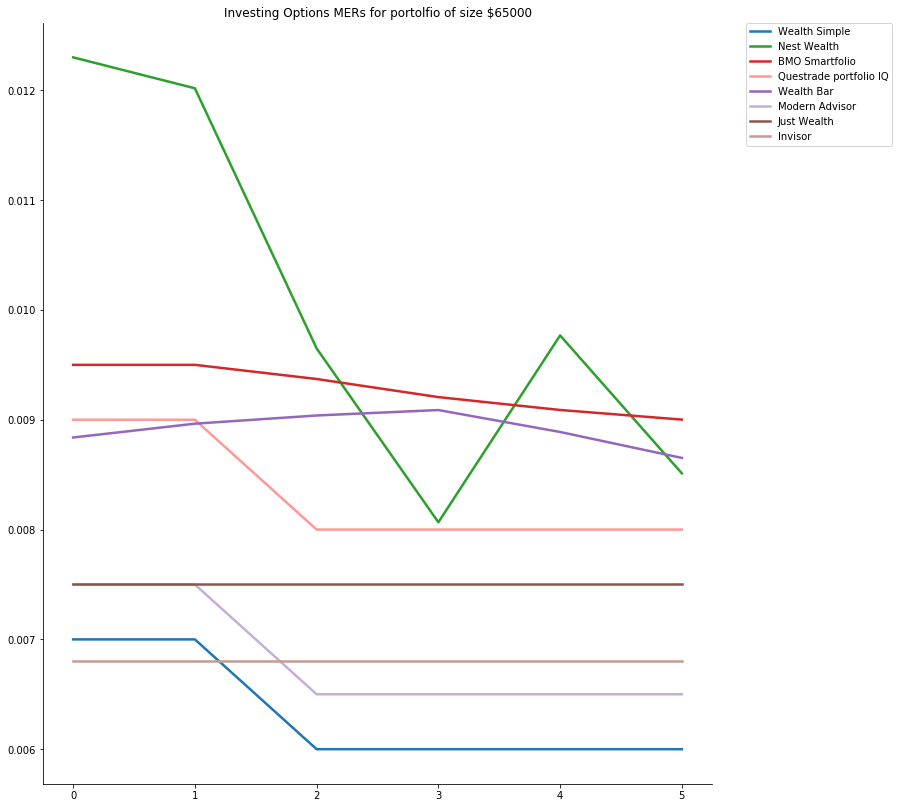

In [36]:
%matplotlib inline

# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)    

    
## You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
##ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
##ax.spines["left"].set_visible(False) 


# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
## making a list of adviosrs for labeling purposes
Advisors  = ['Wealth Simple', 'Sun Life', 'Mutual funds', 'Tangerine', 'Nest Wealth',
            'DIY ETFs', 'BMO Smartfolio', 'Questrade portfolio IQ', 'Wealth Bar', 
            'Modern Advisor','Just Wealth',  'Invisor', 'RBC Domionion securities'
           , 'TD E series']



## plots lines with labels
plt.plot(year_list, wealth_simple[:,x],lw=2.5, color=tableau20[0], label = Advisors[0])
##plt.plot(year_list, sun_life[:,x],lw=2.5, color=tableau20[1], label = Advisors[1])
##plt.plot(year_list, Mutual_fund[:,x],lw=2.5, color=tableau20[2], label = Advisors[2])
##plt.plot(year_list, tangerine[:,x],lw=2.5, color=tableau20[3], label = Advisors[3])
plt.plot(year_list, nestwealth[:,x],lw=2.5, color=tableau20[4], label = Advisors[4])
##plt.plot(year_list, DIY_ETF[:,x],lw=2.5, color=tableau20[5], label = Advisors[5])
plt.plot(year_list, BMO_smartfolio[:,x],lw=2.5, color=tableau20[6], label = Advisors[6])
plt.plot(year_list, Questrade_port_iq[:,x],lw=2.5, color=tableau20[7], label = Advisors[7])
plt.plot(year_list, wealth_bar[:,x],lw=2.5, color=tableau20[8], label = Advisors[8])
plt.plot(year_list, modern_advisor[:,x],lw=2.5, color=tableau20[9], label = Advisors[9])
plt.plot(year_list, Just_wealth_port[:,x],lw=2.5, color=tableau20[10], label = Advisors[10])
plt.plot(year_list, invisor[:,x],lw=2.5, color=tableau20[11], label = Advisors[11])
##plt.plot(year_list, RBC_dom[:,x],lw=2.5, color=tableau20[12], label = Advisors[12])
##plt.plot(year_list, TD_eserise[:,x],lw=2.5, color=tableau20[13], label = Advisors[13])

## makes title
plt.title('Investing Options MERs for portolfio of size $%s' %(total))

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0.5,1,'Total portfolio size diffrence')

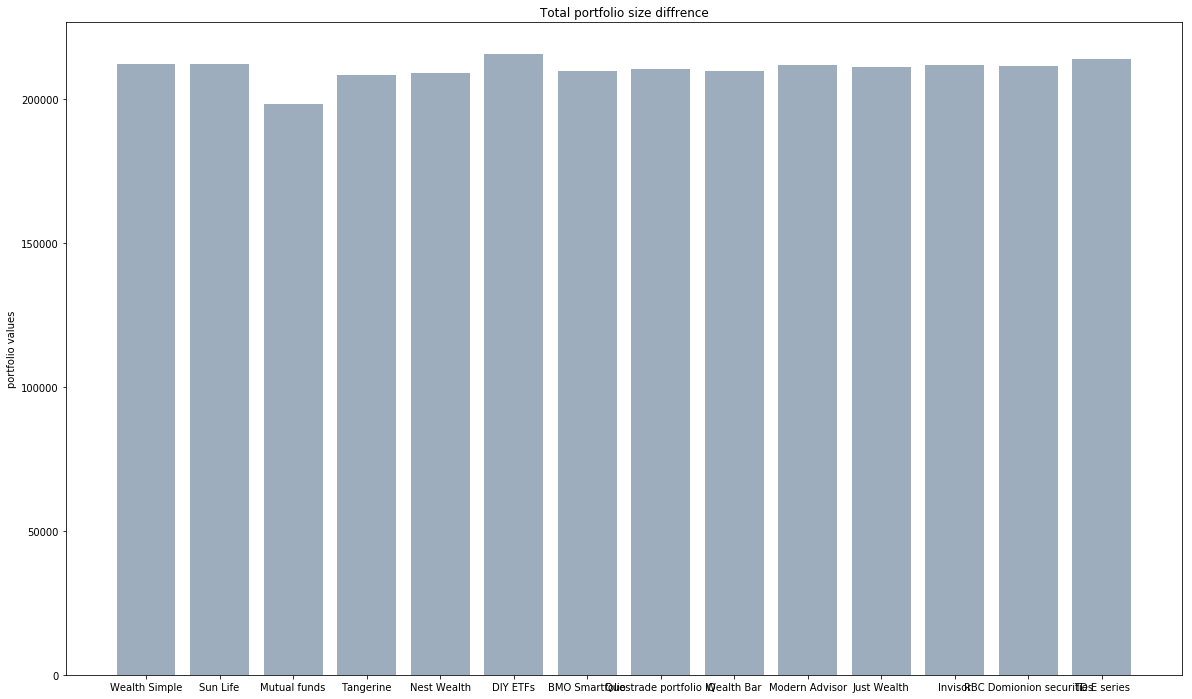

In [37]:


## aggregates x bar data for the last year values
bar_data_x = [wealth_simple[-1,0], sun_life[-1:,0], Mutual_fund[-1:,0], tangerine[-1:,0],nestwealth[-1:,0],
             DIY_ETF[-1:,0], BMO_smartfolio[-1:,0], Questrade_port_iq[-1:,0], wealth_bar[-1:,0],
              modern_advisor[-1:,0], Just_wealth_port[-1:,0], invisor[-1:,0], RBC_dom[-1:,0], TD_eserise[-1:,0]]

## relists the advisors for easier code review
Advisors  = ['Wealth Simple', 'Sun Life', 'Mutual funds', 'Tangerine', 'Nest Wealth',
            'DIY ETFs', 'BMO Smartfolio', 'Questrade portfolio IQ', 'Wealth Bar', 
            'Modern Advisor','Just Wealth',  'Invisor', 'RBC Domionion securities'
           , 'TD E series']

## plots a bar graph of the final values
plt.figure(figsize=(20, 12))    
y_pos = np.arange(len(Advisors))
 
    ## formates the graph
plt.bar(y_pos, bar_data_x, align='center', alpha=0.5, color="#3F5D7D")
plt.xticks(y_pos, Advisors)
plt.ylabel('portfolio values')
plt.title('Total portfolio size diffrence')


In [38]:
## removes the brackets around elements of the list
def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

## initalizes the index
i = 0
for x in Advisors:
    ## rounds to the nearest dollar
    temp = np.round(bar_data_x[i], 0) 
    ## prints the portfolio and the values
    print( x,'ending portfolio balance is $', listToStringWithoutBrackets(temp))  
    ## iterates to the next index
    i = i + 1

Wealth Simple ending portfolio balance is $ 212207.0
Sun Life ending portfolio balance is $  212054.
Mutual funds ending portfolio balance is $  198487.
Tangerine ending portfolio balance is $  208347.
Nest Wealth ending portfolio balance is $  209222.
DIY ETFs ending portfolio balance is $  215848.
BMO Smartfolio ending portfolio balance is $  209611.
Questrade portfolio IQ ending portfolio balance is $  210474.
Wealth Bar ending portfolio balance is $  209893.
Modern Advisor ending portfolio balance is $  211772.
Just Wealth ending portfolio balance is $  211100.
Invisor ending portfolio balance is $  211706.
RBC Domionion securities ending portfolio balance is $  211367.
TD E series ending portfolio balance is $  214062.


Text(0.5,1,'Total portfolio size diffrence')

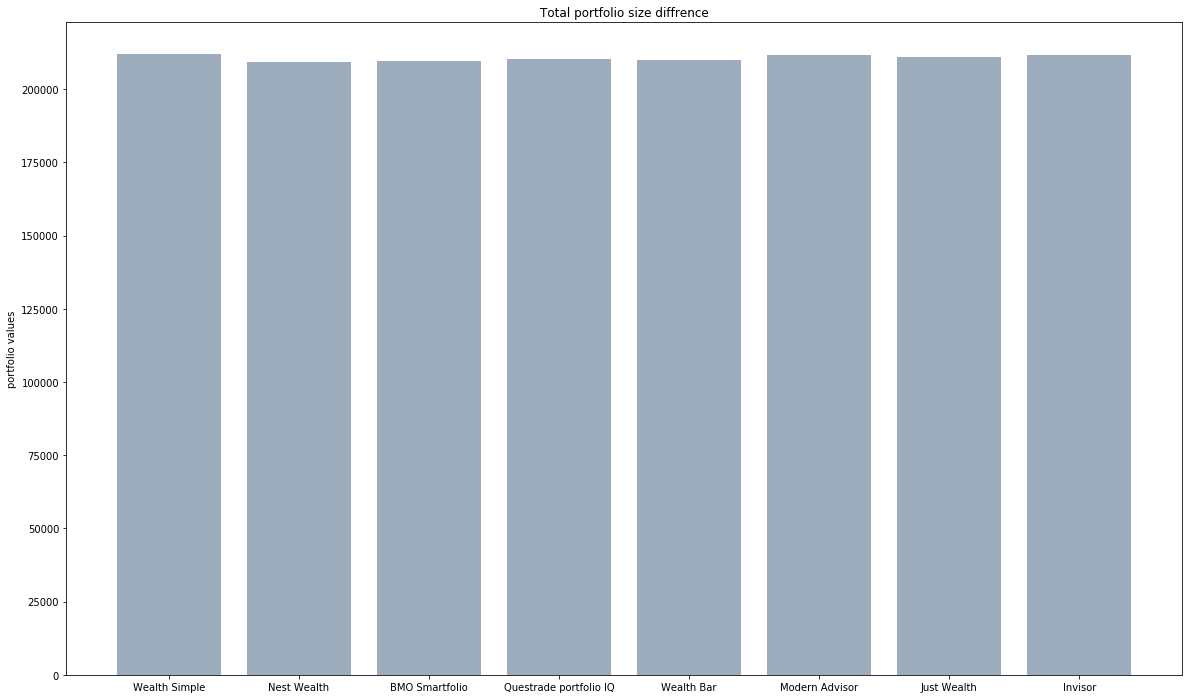

In [42]:


## aggregates x bar data for the last year values
bar_data_x = [wealth_simple[-1,0],nestwealth[-1:,0],
             BMO_smartfolio[-1:,0], Questrade_port_iq[-1:,0], wealth_bar[-1:,0],
              modern_advisor[-1:,0], Just_wealth_port[-1:,0], invisor[-1:,0], ]

## relists the advisors for easier code review
Advisors  = ['Wealth Simple',  'Nest Wealth',
             'BMO Smartfolio', 'Questrade portfolio IQ', 'Wealth Bar', 
            'Modern Advisor','Just Wealth',  'Invisor',  'Tangerine'
          ]

## plots a bar graph of the final values
plt.figure(figsize=(20, 12))    
y_pos = np.arange(len(Advisors))
 
    ## formates the graph
plt.bar(y_pos, bar_data_x, align='center', alpha=0.5, color="#3F5D7D")
plt.xticks(y_pos, Advisors)
plt.ylabel('portfolio values')
plt.title('Total portfolio size diffrence')

In [41]:

## removes the brackets around elements of the list
def listToStringWithoutBrackets(list1):
    return str(list1).replace('[','').replace(']','')

## initalizes the index
i = 0
for x in Advisors:
    ## rounds to the nearest dollar
    temp = np.round(bar_data_x[i], 0) 
    ## prints the portfolio and the values
    print( x,'ending portfolio balance is $', listToStringWithoutBrackets(temp))  
    ## iterates to the next index
    i = i + 1

Wealth Simple ending portfolio balance is $ 212207.0
Sun Life ending portfolio balance is $  212054.
Mutual funds ending portfolio balance is $  198487.
Nest Wealth ending portfolio balance is $  209222.
BMO Smartfolio ending portfolio balance is $  209611.
Questrade portfolio IQ ending portfolio balance is $  210474.
Wealth Bar ending portfolio balance is $  209893.
Modern Advisor ending portfolio balance is $  211772.
Just Wealth ending portfolio balance is $  211100.
Invisor ending portfolio balance is $  211706.
